In this notebook, you will find graphs representing results from simulations previously run, so you can compare your results with these

In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadr
import pathlib
from leap.simulation import Simulation
from leap.logger import get_logger

### Running Simulation From Jupyter
<span style="color:yellow">Currently, the simulations take much to long to run, so calling simulation.run() in the Jupyter notebook and using the generated outcome_matrix object for analysis is infeasible. Instead, run it seperately and use the outputted csvs!</span>

In [1]:
# # setup the logger
# logger = get_logger(__name__)

# set output path to output/jupter folder in root
output_path = pathlib.Path("/home/me/pharmsci/leap/output/jupyter_revised")
simulation = Simulation(min_year=2001, province="CA", population_growth_type="M3", ignore_pollution_flag=True)
repr(simulation)

NameError: name 'get_logger' is not defined

In [6]:
# # check if path exists before running
# if not output_path.exists():
#     raise Exception(f"Please input a correct output path.\nPath was <{output_path}>")

# logger.message("Running simulation...")
# outcome_matrix = simulation.run()
# logger.message(outcome_matrix)
# outcome_matrix.save(path=output_path)

[MESSAGE]: Running simulation...


Agent 9f4435: 100%|██████████| 9443/9443
Agent db76d9: 100%|██████████| 171/171
Agent a7cba9: 100%|██████████| 156/156
Agent b2e086: 100%|██████████| 161/161
Agent 5075fa: 100%|██████████| 165/165
Agent d9d3d6: 100%|██████████| 172/172
Agent b8c715: 100%|██████████| 171/171
Agent f8f7fa: 100%|██████████| 184/184
Agent 09b3f9: 100%|██████████| 192/192
Agent 1d5595: 100%|██████████| 192/192
Agent aaf66c: 100%|██████████| 183/183
Agent 2e32f4: 100%|██████████| 194/194
Agent 58cd85: 100%|██████████| 192/192
Agent cb6b75: 100%|██████████| 191/191
Agent 10e4a3: 100%|██████████| 169/169
Agent 2dd920: 100%|██████████| 211/211
Agent 7c670b: 100%|██████████| 218/218
Agent 13293a: 100%|██████████| 246/246
Agent b5989d: 100%|██████████| 253/253
Year 2019: 100%|██████████| 19/19


[MESSAGE]: OutcomeMatrix

until_all_die:
False

min_year:
2001

max_year:
2019

max_age:
111

_alive:
      year  age sex  n_alive
0     2001    0   F       47
1     2001    0   M       53
2     2001    1   F       58
3     2001    1   M       47
4     2001    2   F       57
...    ...  ...  ..      ...
4251  2019  109   M        0
4252  2019  110   F        0
4253  2019  110   M        0
4254  2019  111   F        0
4255  2019  111   M        0

[4256 rows x 4 columns]

_antibiotic_exposure:
      year  age sex  n_antibiotic_exposure
0     2001    0   F                     41
1     2001    0   M                     60
2     2001    1   F                     42
3     2001    1   M                     51
4     2001    2   F                     38
...    ...  ...  ..                    ...
4251  2019  109   M                      0
4252  2019  110   F                      0
4253  2019  110   M                      0
4254  2019  111   F                      0
4255  2019  111   M          

### Historic Data and Projections Investigation

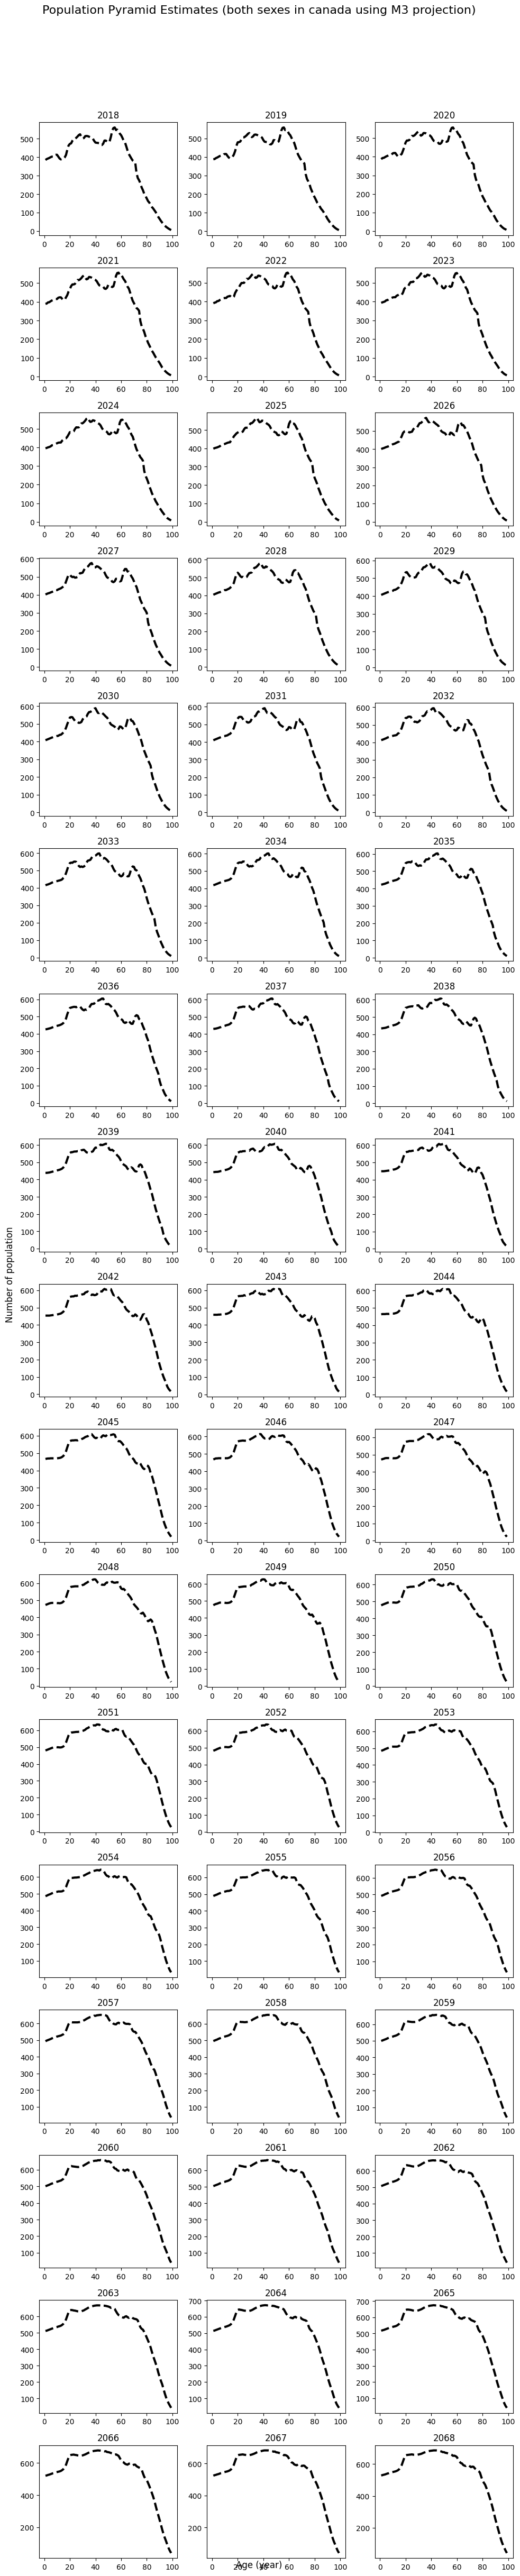

In [8]:
def get_projection_scenario_abbreviation(longtext: str):
    """
    Description
    ----------
    Extracts the 2-character abbreviation from a projection scenario description.

    Parameters
    ----------
    longtext : str
        The full description of the projection scenario, in the format 
        'Projection scenario XX: description', where 'XX' is the 2-character abbreviation.

    Returns
    ----------
    abbreviation : str
        The 2-character abbreviation of the projection scenario.

    Examples
    ----------
    >>> get_projection_scenario_abbreviation('Projection scenario LG: low-growth') = 'LG'
    >>> get_projection_scenario_abbreviation('Projection scenario M1: medium-growth') = 'M1'
    """
    # longtext looks like 'Projection scenario LG: low-growth'
    parts = longtext.split(':')
    # parts looks = ['Projection scenario LG', 'low-growth']
    first_part = parts[0]
    # first_part looks like 'Projection scenario LG'
    abbreviation = first_part[-2:]  # get last 2 chars of string
    # abbreviation looks like 'LG'
    return abbreviation


# Read the RDS file
pop_proj: pd.DataFrame = pyreadr.read_r("leap/processed_data/pop_projection_BC_CA.rds")[None]
# Rename columns
pop_proj.rename(columns={'REF_DATE': 'year',
                         'GEO': 'province',
                         'Sex': 'sex',
                         'Projection_scenario': 'projection_scenario',
                         'Age_group': 'age',
                         'VALUE': 'n'}, inplace=True)
# Change year to type int
pop_proj['year'] = pop_proj['year'].astype(int)
# Fill NaN values in 'n' column with 0 and then change to type int
pop_proj['n'] = pop_proj['n'].fillna(0).astype(int)
# Map long province names to abbreviations
pop_proj['province'] = pop_proj['province'].map({'Canada': 'CA', 'British Columbia': 'BC'})
# Map projection_scenario to use only the 2 character abbreviation
pop_proj['projection_scenario'] = pop_proj['projection_scenario'].apply(
    get_projection_scenario_abbreviation)
# Map sex to use 1 character abbreviation
pop_proj['sex'] = pop_proj['sex'].map({'Both sexes': 'B', 'Males': 'M', 'Females': 'F'})
# Remove rows with age ranges to only include one age per row
pop_proj = pop_proj[pop_proj['age'].str.match(r'^\d{1,2} years?$')]
# Convert column age to ints by only keeping number part
pop_proj['age'] = pop_proj['age'].str.extract(r'(\d+)').astype(int)
pop_proj.head()


# Figure Parameters
num_cols = 3
figure_years = range(pop_proj['year'].min(), pop_proj['year'].max() + 1)
num_rows = (len(figure_years) + num_cols - 1) // num_cols  # Calculate the number of rows needed
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 50))

for i, year in enumerate(figure_years):
    ax: plt.Axes = axs[i // num_cols][i % num_cols]

    # Filter stats data by current year
    # Filter data for the year 2018 and projection scenario type M3
    data_year = pop_proj[(pop_proj['year'] == year) &
                         (pop_proj['projection_scenario'] == 'M3') &
                         (pop_proj['sex'] == 'B') &
                         (pop_proj['province'] == 'CA')]

    ax.plot(data_year["age"], data_year["n"],
            color="black", linestyle="dashed", linewidth=3, label="observed")

    # Title and Labels
    ax.set_title(f"{year}", fontsize=12)

fig.supxlabel("Age (year)")
fig.supylabel("Number of population")
fig.suptitle("Population Pyramid Estimates (both sexes in canada using M3 projection)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Figure 5. Population by age across selected years from the model (grey solid) and from Statistics Canada (black dashed).

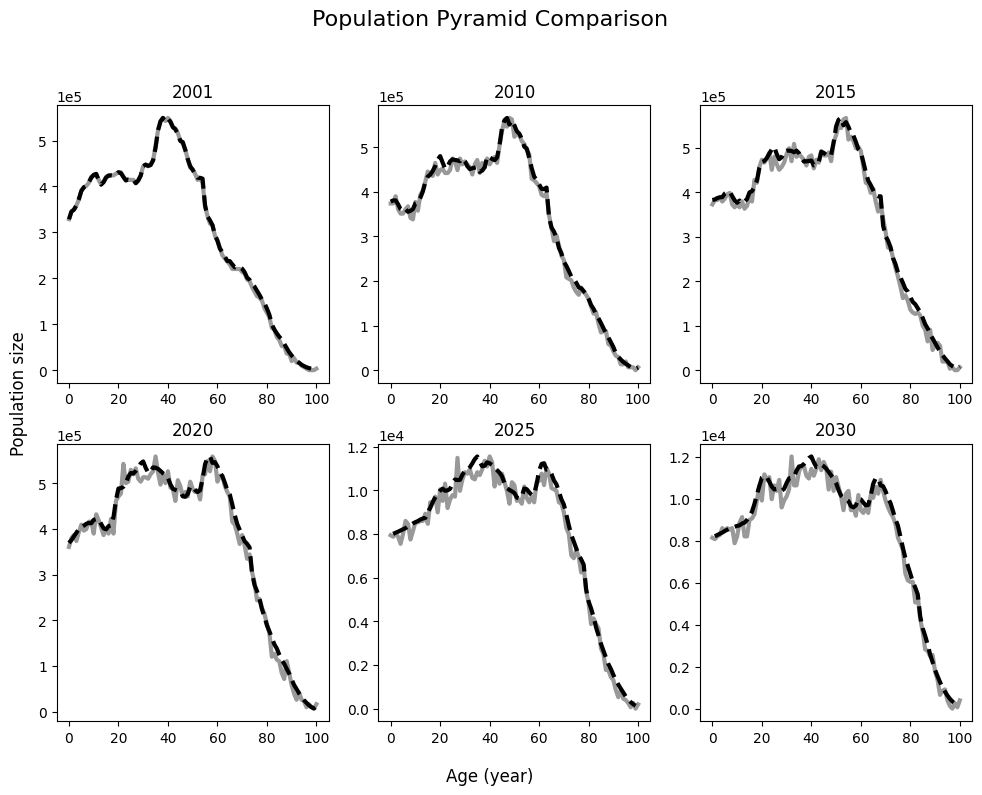

In [14]:
# Figure 5. Population by age across selected years from the model (grey solid) and from Statistics Canada (black dashed).

# Simulation parametres
chosen_province = "CA"
baseline_year = 2001
growth_type = "M3"

# Figure Parameters
num_cols = 3
num_rows = 2
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]

# Read in population data from StatsCanada
canada_initial_pop_df = pd.read_csv("leap/processed_data/initial_pop_distribution.csv")
canada_initial_pop_df = canada_initial_pop_df.query("province == @chosen_province and year >= @baseline_year")

# Read in population data from simulation
simulation_df = pd.read_csv("output/BIG_CA_30/outcome_matrix_alive.csv")
simulation_df = simulation_df.query("year >= @baseline_year")

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 8))

for i, year in enumerate(figure_years):
    ax : plt.Axes = axs[i // num_cols][i % num_cols]
    
    # Filter stats data by current year
    if i < 4:
        canada_pop_filtered_df = canada_initial_pop_df.query("year == @year")
    else:
        canada_pop_filtered_df = pop_proj.query("year == @year")
    canada_pop_totaled_df = canada_pop_filtered_df.groupby("age").sum().reset_index()
    
    # Filter simulation data by current year
    simulation_pop_filtered_df = simulation_df[(simulation_df["year"] == year) &
                                           (simulation_df["age"] <= 100)]
    simulation_pop_totaled_df = simulation_pop_filtered_df.groupby("age").sum().reset_index()
    # Scale the simulation data to match the maximum population of the stats data
    scaling_factor = canada_pop_totaled_df["n"].max() / simulation_pop_totaled_df["n_alive"].max()
    simulation_pop_totaled_df["n_alive"] *= scaling_factor
    
    # Plot simulation data
    ax.plot(simulation_pop_totaled_df["age"], simulation_pop_totaled_df["n_alive"],
            color="#999999", linestyle="-", linewidth=3, label="simulated")
    # Plot historical and projected data from Stats Canada
    ax.plot(canada_pop_totaled_df["age"], canada_pop_totaled_df["n"],
            color="black", linestyle="dashed", linewidth=3, label="observed")


    # Title and Labels
    ax.set_title(f"{year}", fontsize=12)
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

fig.supxlabel("Age (year)")
fig.supylabel("Population size")
fig.suptitle("Population Pyramid Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Figure 6. Rate of antibiotic prescriptions by sex (red: females; blue: males) for simulated (solid) and target values (dotted), with the floor rate of 50 per 1,000 (purple).

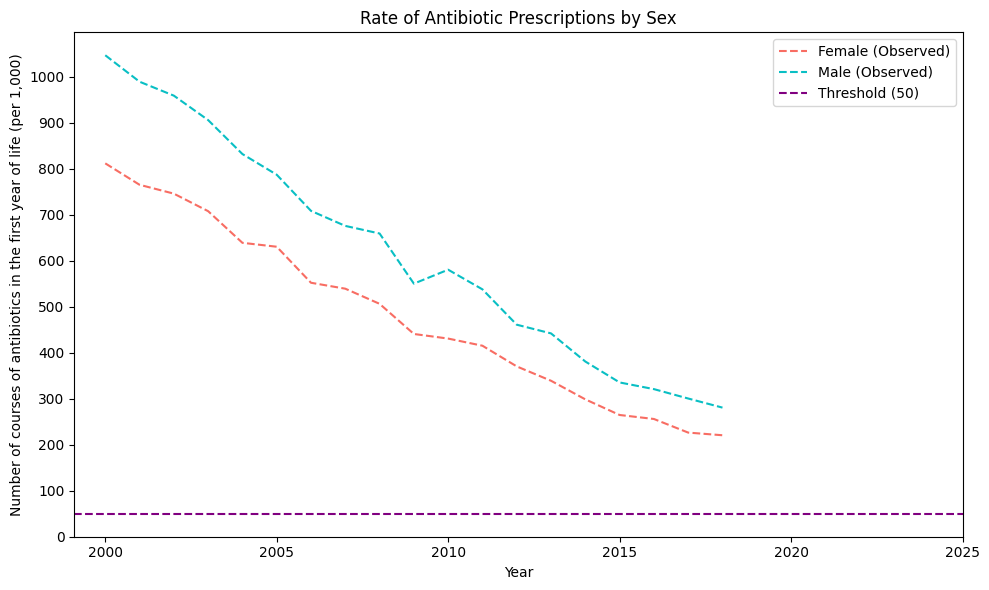

In [16]:
# Figure 6. Rate of antibiotic prescriptions by sex (red: females; blue: males) for simulated (solid) and target values (dotted), with the floor rate of 50 per 1,000 (purple).

# Read in antibiotic data from StatsCanada
canada_infant_abx_df = pd.read_csv("leap/processed_data/InfantAbxBC.csv")

# Plotting
plt.figure(figsize=(10, 6))

# Define colors to plot for different sexs
sex_colour_dict = {"Male": "#09bfc4", "Female": "#f86d63"}

# Dotted lines from count_data
for sex in canada_infant_abx_df['sex'].unique():
    # sex in ['Female', 'Male']
    canada_infant_abx_filtered = canada_infant_abx_df[canada_infant_abx_df['sex'] == sex]
    plt.plot(
        canada_infant_abx_filtered['year'],
        canada_infant_abx_filtered['rate'],
        c=sex_colour_dict[sex],
        linestyle='dashed',
        label=f"{sex} (Observed)"
    )

# Additional elements
plt.axhline(y=50, color='purple', linestyle='dashed', label="Threshold (50)")
plt.ylabel("Number of courses of antibiotics in the first year of life (per 1,000)")
plt.xlabel("Year")
plt.xticks(range(canada_infant_abx_df['year'].min(), 2030, 5))
plt.yticks(range(0, 1100, 100))
plt.legend(title="")
plt.title("Rate of Antibiotic Prescriptions by Sex")

# Save the figure
plt.tight_layout()
plt.show()

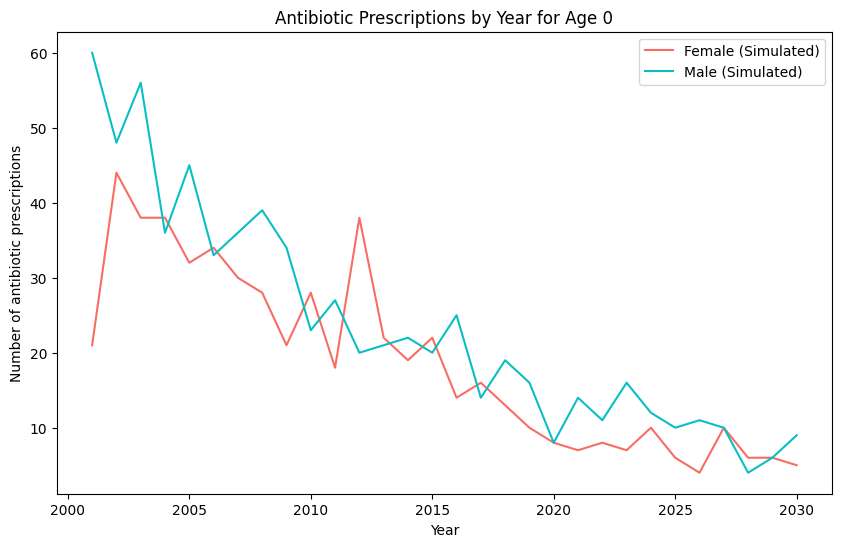

In [ ]:
# Read in antibiotic data from simulation
simulation_infant_abx_df = pd.read_csv("output/BIG_CA_30/outcome_matrix_antibiotic_exposure.csv")
simulation_infant_abx_df['sex'] = simulation_infant_abx_df['sex'].map(lambda s: "Female" if s == "F" else "Male")
simulation_infant_abx_totaled_df : pd.DataFrame = simulation_infant_abx_df.groupby(["year", "sex"]).sum().reset_index()

# Filter data for age 0
simulation_age0_abx_df = simulation_infant_abx_df.query("age == 0")

# Plotting
plt.figure(figsize=(10, 6))

# Plot for Female
simulation_age0_abx_F_df = simulation_age0_abx_df.query("sex == 'Female'")
plt.plot(simulation_age0_abx_F_df['year'], simulation_age0_abx_F_df['n_antibiotic_exposure'], label='Female (Simulated)', color=sex_colour_dict['Female'], linestyle='solid')

# Plot for Male
simulation_age0_abx_M_df = simulation_age0_abx_df.query("sex == 'Male'")
plt.plot(simulation_age0_abx_M_df['year'], simulation_age0_abx_M_df['n_antibiotic_exposure'], label='Male (Simulated)', color=sex_colour_dict['Male'], linestyle='solid')

# Additional elements
plt.xlabel("Year")
plt.ylabel("Number of antibiotic prescriptions")
plt.title("Antibiotic Prescriptions by Year for Age 0")
plt.legend()
plt.show()


### Figure 7. Asthma prevalence rates per 1,000 general population by sex (left: females; right: males) from the model (grey solid) and estimated or projected (black dashed).

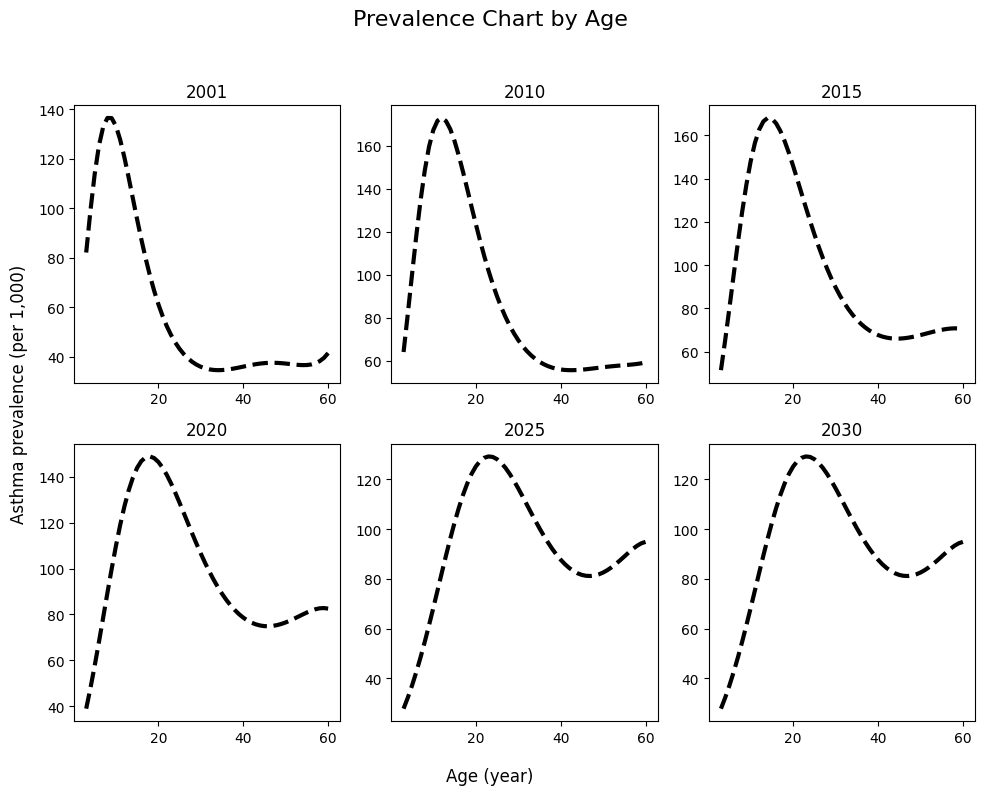

In [2]:
# Figure 7. Asthma prevalence rates per 1,000 general population by sex (left: females; right: males) from the model (grey solid) and estimated or projected (black dashed).

# Simulation parametres
chosen_province = "CA"
baseline_year = 2001
growth_type = "M3"

# Figure Parameters
num_cols = 3
num_rows = 2
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]

# Read and process observed asthma incidence data
asthma_inc = (
    pd.read_csv("leap/processed_data/master_asthma_prev_inc.csv")
    .map(lambda s: "F" if s == 0 else "M")
)

# Read and process obsereved asthma prevalence data
asthma_prev = pd.read_csv("leap/processed_data/master_asthma_prev_inc.csv")
asthma_prev = asthma_prev[asthma_prev["age"] <= 60]
asthma_prev['sex'] = asthma_prev['sex'].map(lambda s: "F" if s == 0 else "M")

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 8))

for i, year in enumerate(figure_years):
    ax: plt.Axes = axs[i // num_cols][i % num_cols]

    # Filter stats data by current year
    canada_pop_filtered_df = (
        asthma_prev.query("year == @year and sex == 'M'")
        .groupby("age").sum().reset_index()
    )
    canada_pop_filtered_df["prev"] *= 800

    ax.plot(canada_pop_filtered_df["age"], canada_pop_filtered_df["prev"],
            color="black", linestyle="dashed", linewidth=3)

    # Title and Labels
    ax.set_title(f"{year}", fontsize=12)

fig.supxlabel("Age (year)")
fig.supylabel("Asthma prevalence (per 1,000)")
fig.suptitle("Prevalence Chart by Age", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()